### get the consensus motifs from retrained Base_model1_10000, 9000 and 8000; get the consensus motifs from Base_model2_10000, 9000 and 8000 and compare the consensus motifs from the two model structures

In [44]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
import pandas as pd
import numpy as np
import os
import random
from collections import defaultdict, Counter
from itertools import combinations
import json
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
import optuna
# from torchmetrics.classification import F1Score
import pickle
import sys
### import Dataset prepartion and model training classes from BS_LS_scripts folder
sys.path.insert(1, '/home/wangc90/circRNA/circRNA_Data/BS_LS_scripts/')
from BS_LS_DataSet import BS_LS_DataSet_Prep, BS_LS_upper_lower_rcm
# from BS_LS_Training_Best_Base_model2 import Objective, Objective_CV
from PPM_extraction import PPM_extraction

random.seed(2023)
torch.manual_seed(2023)

### extract motifs for 10000 training size

In [45]:
BS_LS_coordinates_path = '/home/wangc90/circRNA/circRNA_Data/BS_LS_data/updated_data/BS_LS_coordinates_final.csv'
hg19_seq_dict_json_path = '/home/wangc90/circRNA/circRNA_Data/hg19_seq/hg19_seq_dict.json'
flanking_dict_folder = '/home/wangc90/circRNA/circRNA_Data/BS_LS_data/flanking_dicts/'
bs_ls_dataset = BS_LS_DataSet_Prep(BS_LS_coordinates_path=BS_LS_coordinates_path,
                                   hg19_seq_dict_json_path=hg19_seq_dict_json_path,
                                   flanking_dict_folder=flanking_dict_folder,
                                   flanking_junction_bps=100,
                                   flanking_intron_bps=100,
                                   training_size=10000)


bs_ls_dataset.get_junction_flanking_intron_seq()

### use the 10000 for training RCM and junction seq and use 1000 for combine them
train_key1, _, test_keys = bs_ls_dataset.get_train_test_keys()


chr5|138837130|138837392|- has N in the extracted junctions, belongs to BS
There are 0 overlapped flanking sequence from BS and LS  
There are 7 repeated BS sequences
There are 2 repeated LS sequences


In [46]:
len(train_key1)

20000

### The corresponding retrained_model structure has to be loaded for the motif extraction

### Base_model2_10000

In [47]:
### Model 2 input sequence 4 X 200 + 4 X 200 with 1 or 2CNN layer
class Model2_optuna_upper_10000(nn.Module):
    '''
        This is for 2-d model to process the upper half of the sequence with 1 or 2 CNN
    '''

    def __init__(self, trial):
        super(Model2_optuna_upper_10000, self).__init__()
        # convlayer 1
#         self.out_channel1 = trial.suggest_categorical('upper_out_channel1', [128, 256, 512])
        self.out_channel1 = 512
#         kernel_size1 = trial.suggest_categorical('upper_kernel_size1', [13, 15, 17, 19, 21])
        kernel_size1 = 15

        self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.out_channel1, \
                               kernel_size=kernel_size1, stride=1, padding=(kernel_size1 - 1) // 2)
        self.conv1_bn = nn.BatchNorm1d(self.out_channel1)
#         self.maxpool1 = trial.suggest_categorical('upper_maxpool1', [5, 10, 20])
        self.maxpool1 = 5
        self.conv1_out_dim = 200 // self.maxpool1

#         self.out_channel2 = trial.suggest_categorical('upper_out_channel2', [128, 256, 512])
        self.out_channel2 = 512
#         kernel_size2 = trial.suggest_categorical('upper_kernel_size2', [13, 15, 17, 19, 21])
        kernel_size2 = 21

        self.conv2 = nn.Conv1d(in_channels=self.out_channel1, out_channels=self.out_channel2, \
                               kernel_size=kernel_size2, stride=1, padding=(kernel_size2 - 1) // 2)
        self.conv2_bn = nn.BatchNorm1d(self.out_channel2)
#         self.maxpool2 = trial.suggest_categorical('upper_maxpool2', [5, 10])
        self.maxpool2 = 10
        self.conv2_out_dim = 200 // (self.maxpool1 * self.maxpool2)

    def forward(self, x):
        out = x
        out = torch.relu(self.conv1_bn(self.conv1(out)))
        out = F.max_pool1d(out, self.maxpool1)
        out = torch.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, self.maxpool2)
        out = out.view(-1, self.out_channel2 * self.conv2_out_dim)
        return out


class Model2_optuna_lower_10000(nn.Module):
    '''
        This is for 2-d model to process the upper half of the sequence with 1 or 2 CNN
    '''

    def __init__(self, trial):

        super(Model2_optuna_lower_10000, self).__init__()
        # convlayer 1
#         self.out_channel1 = trial.suggest_categorical('lower_out_channel1', [128, 256, 512])
        self.out_channel1 = 256
#         kernel_size1 = trial.suggest_categorical('lower_kernel_size1', [13, 15, 17, 19, 21])
        kernel_size1 = 13
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.out_channel1, \
                               kernel_size=kernel_size1, stride=1, padding=(kernel_size1 - 1) // 2)
        self.conv1_bn = nn.BatchNorm1d(self.out_channel1)
#         self.maxpool1 = trial.suggest_categorical('lower_maxpool1', [5, 10, 20])
        self.maxpool1 = 5
        self.conv1_out_dim = 200 // self.maxpool1

#         self.out_channel2 = trial.suggest_categorical('lower_out_channel2', [128, 256, 512])
        self.out_channel2 = 512
#         kernel_size2 = trial.suggest_categorical('lower_kernel_size2', [13, 15, 17, 19, 21])
        kernel_size2 = 21
        self.conv2 = nn.Conv1d(in_channels=self.out_channel1, out_channels=self.out_channel2, \
                               kernel_size=kernel_size2, stride=1, padding=(kernel_size2 - 1) // 2)
        self.conv2_bn = nn.BatchNorm1d(self.out_channel2)
#         self.maxpool2 = trial.suggest_categorical('lower_maxpool2', [5, 10])
        self.maxpool2 = 10
        self.conv2_out_dim = 200 // (self.maxpool1 * self.maxpool2)

    def forward(self, x):
        out = x
        out = torch.relu(self.conv1_bn(self.conv1(out)))
        out = F.max_pool1d(out, self.maxpool1)
        out = torch.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, self.maxpool2)
        out = out.view(-1, self.out_channel2 * self.conv2_out_dim)
        return out

    
class ConcatModel2_optuna_10000(nn.Module):
    def __init__(self, trial):

        super(ConcatModel2_optuna_10000, self).__init__()
        ### cnn for the upper half sequence
        self.cnn_upper = Model2_optuna_upper_10000(trial)

        # this is for two convlayer
        self.upper_out_dim = self.cnn_upper.conv2_out_dim
        self.upper_out_channel = self.cnn_upper.out_channel2

        ### cnn for the lower half sequence
        self.cnn_lower = Model2_optuna_lower_10000(trial)

            # this is for two convlayer
        self.lower_out_dim = self.cnn_lower.conv2_out_dim
        self.lower_out_channel = self.cnn_lower.out_channel2

        self.upper_lower_concate_fc1_in = self.upper_out_channel * self.upper_out_dim + \
                                 self.lower_out_channel * self.lower_out_dim

#         self.upper_lower_concate_fc1_out = trial.suggest_categorical('concat_fc1_out', [128, 256, 512])
        self.upper_lower_concate_fc1_out = 512

        self.upper_lower_concate_fc1 = nn.Linear(self.upper_lower_concate_fc1_in, self.upper_lower_concate_fc1_out)

        self.upper_lower_concate_fc1_bn = nn.BatchNorm1d(self.upper_lower_concate_fc1_out)

#         dropout_rate_fc1 = trial.suggest_categorical("concat_dropout_rate_fc1",  [0, 0.1, 0.2, 0.4])
        dropout_rate_fc1 = 0
        self.drop_nn1 = nn.Dropout(p=dropout_rate_fc1)

        # fc layer2
        # use dimension output with nn.CrossEntropyLoss()
#         self.upper_lower_concate_fc2_out = trial.suggest_categorical('concat_fc2_out', [4, 8, 16, 32])
        self.upper_lower_concate_fc2_out = 4
        self.upper_lower_concate_fc2 = nn.Linear(self.upper_lower_concate_fc1_out, self.upper_lower_concate_fc2_out)
        self.upper_lower_concate_fc2_bn = nn.BatchNorm1d(self.upper_lower_concate_fc2_out)

#         dropout_rate_fc2 = trial.suggest_categorical("concat_dropout_rate_fc2", [0, 0.1, 0.2, 0.4])
        dropout_rate_fc2 = 0
        self.drop_nn2 = nn.Dropout(p=dropout_rate_fc2)

        self.upper_lower_concate_final = nn.Linear(self.upper_lower_concate_fc2_out, 2)

        
    def forward(self, seq_upper_feature, seq_lower_feature):

        # obatin the result from the cnn upper
        x1 = self.cnn_upper(seq_upper_feature)

        # obtain the result from the cnn lower
        x2 = self.cnn_lower(seq_lower_feature)

        x = torch.cat((x1, x2), dim=1)

        # feed the concatenated feature to fc1
        out = self.upper_lower_concate_fc1(x)
        out = self.drop_nn1(torch.relu(self.upper_lower_concate_fc1_bn(out)))

        out = self.upper_lower_concate_fc2(out)
        out = self.drop_nn2(torch.relu(self.upper_lower_concate_fc2_bn(out)))

        out = self.upper_lower_concate_final(out)

        return out


Base_model2_10000: upper: self.out_channel1 = 512; kernel_size1 = 15; padding=(kernel_size1 - 1) // 2 = 7

In [48]:
### https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254
### https://github.com/uci-cbcl/DanQ/issues/9

### upper kernel 4 X 15 , padding 7

model_path = "/home/wangc90/circRNA/circRNA_Data/model_outputs/Base_model2_retraining/Base_model2_retraining_10000/retrained_model_149.pt"

Base_model2_10000_ppm_extraction_BS_upper = PPM_extraction(train_instances='BS',
                                                           train_key=train_key1,
                                                           is_upper=True,
                                                           is_lower=False,
                                                           is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=7,
                               kernel_len=15, ppm_file_name='Base_model2_10000_BS_upper_kernel_512_PPM')

Base_model2_10000_ppm_extraction_BS_upper.write_out_PPM()

extract the motifs for LS exon pairs

In [49]:
Base_model2_10000_ppm_extraction_LS_upper = PPM_extraction(train_instances='LS', train_key=train_key1, is_upper=True,
                                         is_lower=False,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=7,
                               kernel_len=15, ppm_file_name='Base_model2_10000_LS_upper_kernel_512_PPM')

Base_model2_10000_ppm_extraction_LS_upper.write_out_PPM()

Base_model2_10000: lower: self.out_channel1 = 256; kernel_size1 = 13; padding=(kernel_size1 - 1) // 2 = 6

In [50]:
Base_model2_10000_ppm_extraction_BS_lower = PPM_extraction(train_instances='BS', train_key=train_key1, is_upper=False,
                                         is_lower=True,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=6,
                               kernel_len=13, ppm_file_name='Base_model2_10000_BS_lower_kernel_256_PPM')

Base_model2_10000_ppm_extraction_BS_lower.write_out_PPM()

extract the motifs for LS exon pairs

In [51]:
Base_model2_10000_ppm_extraction_LS_lower = PPM_extraction(train_instances='LS', train_key=train_key1, is_upper=False,
                                         is_lower=True,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=6,
                               kernel_len=13, ppm_file_name='Base_model2_10000_LS_lower_kernel_256_PPM')

Base_model2_10000_ppm_extraction_LS_lower.write_out_PPM()

### Base_model1_10000

In [52]:
class Model1_optuna_10000(nn.Module):
    '''
        This model take in input sequence 4 X 400 with 1 CNN layer
    '''

    def __init__(self, trial):

        super(Model1_optuna_10000, self).__init__()
        ### first CNN layer
#         self.out_channel1 = trial.suggest_categorical('out_channel1', [128, 256, 512])
        self.out_channel1 = 512
#         kernel_size1 = trial.suggest_categorical('kernel_size1', [13, 15, 17, 19, 21])
        kernel_size1 = 17
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.out_channel1, \
                               kernel_size=kernel_size1, stride=1, padding=(kernel_size1 - 1) // 2)
        self.conv1_bn = nn.BatchNorm1d(self.out_channel1)
#         self.maxpool1 = trial.suggest_categorical('maxpool1', [5, 10, 20])
        self.maxpool1 = 5
        self.conv1_out_dim = 400 // self.maxpool1

#         self.out_channel2 = trial.suggest_categorical('out_channel2', [128, 256, 512])
        self.out_channel2 = 512
#         kernel_size2 = trial.suggest_categorical('kernel_size2', [13, 15, 17, 19, 21])
        kernel_size2 = 21
        self.conv2 = nn.Conv1d(in_channels=self.out_channel1, out_channels=self.out_channel2, \
                                   kernel_size=kernel_size2, stride=1, padding=(kernel_size2 - 1) // 2)
        self.conv2_bn = nn.BatchNorm1d(self.out_channel2)
#         self.maxpool2 = trial.suggest_categorical('maxpool2', [5, 10, 20])
        self.maxpool2 = 10
        self.conv2_out_dim = 400 // (self.maxpool1 * self.maxpool2)

    def forward(self, x):
        out = x
        out = torch.relu(self.conv1_bn(self.conv1(out)))
        out = F.max_pool1d(out, self.maxpool1)
        out = torch.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, self.maxpool2)
        out = out.view(-1, self.out_channel2 * self.conv2_out_dim)
        return out

    
class ConcatModel1_optuna_10000(nn.Module):
    def __init__(self, trial):

        super(ConcatModel1_optuna_10000, self).__init__()

        ### cnn for the concatenated sequence
        self.cnn = Model1_optuna_10000(trial)

        # this is for two convlayer
        self.out_dim = self.cnn.conv2_out_dim
        self.out_channel = self.cnn.out_channel2

        self.fc1_input_dim = self.out_channel * self.out_dim

#         self.fc1_out = trial.suggest_categorical('concat_fc1_out', [128, 256, 512])
        self.fc1_out = 128
        self.fc1 = nn.Linear(self.fc1_input_dim, self.fc1_out)

        self.fc1_bn = nn.BatchNorm1d(self.fc1_out)

#         dropout_rate_fc1 = trial.suggest_categorical("concat_dropout_rate_fc1",  [0, 0.1, 0.2, 0.4])
        dropout_rate_fc1 = 0
        self.drop_nn1 = nn.Dropout(p=dropout_rate_fc1)

        # fc layer2
        # use dimension output with nn.CrossEntropyLoss()
#         self.fc2_out = trial.suggest_categorical('concat_fc2_out', [4, 8, 16, 32])
        self.fc2_out = 4
        self.fc2 = nn.Linear(self.fc1_out, self.fc2_out)

        self.fc2_bn = nn.BatchNorm1d(self.fc2_out)

#         dropout_rate_fc2 = trial.suggest_categorical("concat_dropout_rate_fc2",[0, 0.1, 0.2, 0.4])
        dropout_rate_fc2 = 0

        self.drop_nn2 = nn.Dropout(p=dropout_rate_fc2)

        self.fc3 = nn.Linear(self.fc2_out, 2)

    def forward(self, seq_upper_lower_feature):

        x = self.cnn(seq_upper_lower_feature)
        # feed the concatenated feature to fc1
        out = self.fc1(x)
        out = self.drop_nn1(torch.relu(self.fc1_bn(out)))

        out = self.fc2(out)
        out = self.drop_nn2(torch.relu(self.fc2_bn(out)))

        out = self.fc3(out)
        return out


Base_model1_10000: self.out_channel1 = 512, kernel_size1 = 17, padding=(kernel_size1 - 1) // 2)

In [53]:
model_path = "/home/wangc90/circRNA/circRNA_Data/model_outputs/Base_model1_retraining/Base_model1_retraining_10000/retrained_model_149.pt"

Base_model1_10000_ppm_extraction_BS = PPM_extraction(train_instances='BS', train_key=train_key1, is_upper=False,
                                         is_lower=False,
                                is_upper_lower_concat=True,
                               model_path=model_path, input_seq_len=400, padding_len=8,
                               kernel_len=17, ppm_file_name='Base_model1_10000_BS_kernel_512_PPM')

Base_model1_10000_ppm_extraction_BS.write_out_PPM()

extract the motifs for LS exon pairs

In [54]:
Base_model1_10000_ppm_extraction_LS = PPM_extraction(train_instances='LS', train_key=train_key1, is_upper=False,
                                         is_lower=False,
                                is_upper_lower_concat=True,
                               model_path=model_path, input_seq_len=400, padding_len=8,
                               kernel_len=17, ppm_file_name='Base_model1_10000_LS_kernel_512_PPM')

Base_model1_10000_ppm_extraction_LS.write_out_PPM()

### extract motifs for 9000 training size

In [55]:
BS_LS_coordinates_path = '/home/wangc90/circRNA/circRNA_Data/BS_LS_data/updated_data/BS_LS_coordinates_final.csv'
hg19_seq_dict_json_path = '/home/wangc90/circRNA/circRNA_Data/hg19_seq/hg19_seq_dict.json'
flanking_dict_folder = '/home/wangc90/circRNA/circRNA_Data/BS_LS_data/flanking_dicts/'
bs_ls_dataset = BS_LS_DataSet_Prep(BS_LS_coordinates_path=BS_LS_coordinates_path,
                                   hg19_seq_dict_json_path=hg19_seq_dict_json_path,
                                   flanking_dict_folder=flanking_dict_folder,
                                   flanking_junction_bps=100,
                                   flanking_intron_bps=100,
                                   training_size=9000)


bs_ls_dataset.get_junction_flanking_intron_seq()

### use the 10000 for training RCM and junction seq and use 1000 for combine them
train_key1, _, test_keys = bs_ls_dataset.get_train_test_keys()


chr5|138837130|138837392|- has N in the extracted junctions, belongs to BS
There are 0 overlapped flanking sequence from BS and LS  
There are 7 repeated BS sequences
There are 2 repeated LS sequences


In [56]:
len(train_key1)

18000

### Base_model2_9000

In [57]:
### Model 2 input sequence 4 X 200 + 4 X 200 with 1 or 2CNN layer
class Model2_optuna_upper_9000(nn.Module):
    '''
        This is for 2-d model to process the upper half of the sequence with 1 or 2 CNN
    '''

    def __init__(self, trial):
        super(Model2_optuna_upper_9000, self).__init__()
        # convlayer 1
#         self.out_channel1 = trial.suggest_categorical('upper_out_channel1', [128, 256, 512])
        self.out_channel1 = 512
#         kernel_size1 = trial.suggest_categorical('upper_kernel_size1', [13, 15, 17, 19, 21])
        kernel_size1 = 21

        self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.out_channel1, \
                               kernel_size=kernel_size1, stride=1, padding=(kernel_size1 - 1) // 2)
        self.conv1_bn = nn.BatchNorm1d(self.out_channel1)
#         self.maxpool1 = trial.suggest_categorical('upper_maxpool1', [5, 10, 20])
        self.maxpool1 = 5
        self.conv1_out_dim = 200 // self.maxpool1

#         self.out_channel2 = trial.suggest_categorical('upper_out_channel2', [128, 256, 512])
        self.out_channel2 = 512
#         kernel_size2 = trial.suggest_categorical('upper_kernel_size2', [13, 15, 17, 19, 21])
        kernel_size2 = 21

        self.conv2 = nn.Conv1d(in_channels=self.out_channel1, out_channels=self.out_channel2, \
                               kernel_size=kernel_size2, stride=1, padding=(kernel_size2 - 1) // 2)
        self.conv2_bn = nn.BatchNorm1d(self.out_channel2)
#         self.maxpool2 = trial.suggest_categorical('upper_maxpool2', [5, 10])
        self.maxpool2 = 10
        self.conv2_out_dim = 200 // (self.maxpool1 * self.maxpool2)

    def forward(self, x):
        out = x
        out = torch.relu(self.conv1_bn(self.conv1(out)))
        out = F.max_pool1d(out, self.maxpool1)
        out = torch.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, self.maxpool2)
        out = out.view(-1, self.out_channel2 * self.conv2_out_dim)
        return out


class Model2_optuna_lower_9000(nn.Module):
    '''
        This is for 2-d model to process the upper half of the sequence with 1 or 2 CNN
    '''

    def __init__(self, trial):

        super(Model2_optuna_lower_9000, self).__init__()
        # convlayer 1
#         self.out_channel1 = trial.suggest_categorical('lower_out_channel1', [128, 256, 512])
        self.out_channel1 = 512
#         kernel_size1 = trial.suggest_categorical('lower_kernel_size1', [13, 15, 17, 19, 21])
        kernel_size1 = 13
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.out_channel1, \
                               kernel_size=kernel_size1, stride=1, padding=(kernel_size1 - 1) // 2)
        self.conv1_bn = nn.BatchNorm1d(self.out_channel1)
#         self.maxpool1 = trial.suggest_categorical('lower_maxpool1', [5, 10, 20])
        self.maxpool1 = 5
        self.conv1_out_dim = 200 // self.maxpool1

#         self.out_channel2 = trial.suggest_categorical('lower_out_channel2', [128, 256, 512])
        self.out_channel2 = 512
#         kernel_size2 = trial.suggest_categorical('lower_kernel_size2', [13, 15, 17, 19, 21])
        kernel_size2 = 21
        self.conv2 = nn.Conv1d(in_channels=self.out_channel1, out_channels=self.out_channel2, \
                               kernel_size=kernel_size2, stride=1, padding=(kernel_size2 - 1) // 2)
        self.conv2_bn = nn.BatchNorm1d(self.out_channel2)
#         self.maxpool2 = trial.suggest_categorical('lower_maxpool2', [5, 10])
        self.maxpool2 = 10
        self.conv2_out_dim = 200 // (self.maxpool1 * self.maxpool2)

    def forward(self, x):
        out = x
        out = torch.relu(self.conv1_bn(self.conv1(out)))
        out = F.max_pool1d(out, self.maxpool1)
        out = torch.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, self.maxpool2)
        out = out.view(-1, self.out_channel2 * self.conv2_out_dim)
        return out

    
class ConcatModel2_optuna_9000(nn.Module):
    def __init__(self, trial):

        super(ConcatModel2_optuna_9000, self).__init__()
        ### cnn for the upper half sequence
        self.cnn_upper = Model2_optuna_upper_9000(trial)

        # this is for two convlayer
        self.upper_out_dim = self.cnn_upper.conv2_out_dim
        self.upper_out_channel = self.cnn_upper.out_channel2

        ### cnn for the lower half sequence
        self.cnn_lower = Model2_optuna_lower_9000(trial)

            # this is for two convlayer
        self.lower_out_dim = self.cnn_lower.conv2_out_dim
        self.lower_out_channel = self.cnn_lower.out_channel2

        self.upper_lower_concate_fc1_in = self.upper_out_channel * self.upper_out_dim + \
                                 self.lower_out_channel * self.lower_out_dim

#         self.upper_lower_concate_fc1_out = trial.suggest_categorical('concat_fc1_out', [128, 256, 512])
        self.upper_lower_concate_fc1_out = 128

        self.upper_lower_concate_fc1 = nn.Linear(self.upper_lower_concate_fc1_in, self.upper_lower_concate_fc1_out)

        self.upper_lower_concate_fc1_bn = nn.BatchNorm1d(self.upper_lower_concate_fc1_out)

#         dropout_rate_fc1 = trial.suggest_categorical("concat_dropout_rate_fc1",  [0, 0.1, 0.2, 0.4])
        dropout_rate_fc1 = 0.2
        self.drop_nn1 = nn.Dropout(p=dropout_rate_fc1)

        # fc layer2
        # use dimension output with nn.CrossEntropyLoss()
#         self.upper_lower_concate_fc2_out = trial.suggest_categorical('concat_fc2_out', [4, 8, 16, 32])
        self.upper_lower_concate_fc2_out = 4
        self.upper_lower_concate_fc2 = nn.Linear(self.upper_lower_concate_fc1_out, self.upper_lower_concate_fc2_out)
        self.upper_lower_concate_fc2_bn = nn.BatchNorm1d(self.upper_lower_concate_fc2_out)

#         dropout_rate_fc2 = trial.suggest_categorical("concat_dropout_rate_fc2", [0, 0.1, 0.2, 0.4])
        dropout_rate_fc2 = 0.1
        self.drop_nn2 = nn.Dropout(p=dropout_rate_fc2)

        self.upper_lower_concate_final = nn.Linear(self.upper_lower_concate_fc2_out, 2)

        
    def forward(self, seq_upper_feature, seq_lower_feature):

        # obatin the result from the cnn upper
        x1 = self.cnn_upper(seq_upper_feature)

        # obtain the result from the cnn lower
        x2 = self.cnn_lower(seq_lower_feature)

        x = torch.cat((x1, x2), dim=1)

        # feed the concatenated feature to fc1
        out = self.upper_lower_concate_fc1(x)
        out = self.drop_nn1(torch.relu(self.upper_lower_concate_fc1_bn(out)))

        out = self.upper_lower_concate_fc2(out)
        out = self.drop_nn2(torch.relu(self.upper_lower_concate_fc2_bn(out)))

        out = self.upper_lower_concate_final(out)

        return out


Base_model2_9000: upper: self.out_channel1 = 512; kernel_size1 = 21; padding=(kernel_size1 - 1) // 2 = 10

In [58]:
model_path = "/home/wangc90/circRNA/circRNA_Data/model_outputs/Base_model2_retraining/Base_model2_retraining_9000/retrained_model_89.pt"

Base_model2_9000_ppm_extraction_BS_upper = PPM_extraction(train_instances='BS', train_key=train_key1, is_upper=True,
                                         is_lower=False,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=10,
                               kernel_len=21, ppm_file_name='Base_model2_9000_BS_upper_kernel_512_PPM')

Base_model2_9000_ppm_extraction_BS_upper.write_out_PPM()

extract the motifs for LS exon pairs

In [59]:
Base_model2_9000_ppm_extraction_LS_upper = PPM_extraction(train_instances='LS', train_key=train_key1, is_upper=True,
                                         is_lower=False,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=10,
                               kernel_len=21, ppm_file_name='Base_model2_9000_LS_upper_kernel_512_PPM')

Base_model2_9000_ppm_extraction_LS_upper.write_out_PPM()

Base_model2_9000: lower: self.out_channel1 = 512; kernel_size1 = 13; padding=(kernel_size1 - 1) // 2 = 6

In [60]:
Base_model2_9000_ppm_extraction_BS_lower = PPM_extraction(train_instances='BS', train_key=train_key1, is_upper=False,
                                         is_lower=True,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=6,
                               kernel_len=13, ppm_file_name='Base_model2_9000_BS_lower_kernel_512_PPM')

Base_model2_9000_ppm_extraction_BS_lower.write_out_PPM()

extract the motifs for LS exon pairs

In [61]:
Base_model2_9000_ppm_extraction_LS_lower = PPM_extraction(train_instances='LS', train_key=train_key1, is_upper=False,
                                         is_lower=True,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=6,
                               kernel_len=13, ppm_file_name='Base_model2_9000_LS_lower_kernel_512_PPM')

Base_model2_9000_ppm_extraction_LS_lower.write_out_PPM()

### Base_model1_9000

In [62]:
class Model1_optuna_9000(nn.Module):
    '''
        This model take in input sequence 4 X 400 with 1 CNN layer
    '''

    def __init__(self, trial):

        super(Model1_optuna_9000, self).__init__()
        ### first CNN layer
#         self.out_channel1 = trial.suggest_categorical('out_channel1', [128, 256, 512])
        self.out_channel1 = 512
#         kernel_size1 = trial.suggest_categorical('kernel_size1', [13, 15, 17, 19, 21])
        kernel_size1 = 13
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.out_channel1, \
                               kernel_size=kernel_size1, stride=1, padding=(kernel_size1 - 1) // 2)
        self.conv1_bn = nn.BatchNorm1d(self.out_channel1)
#         self.maxpool1 = trial.suggest_categorical('maxpool1', [5, 10, 20])
        self.maxpool1 = 5
        self.conv1_out_dim = 400 // self.maxpool1

#         self.out_channel2 = trial.suggest_categorical('out_channel2', [128, 256, 512])
        self.out_channel2 = 512
#         kernel_size2 = trial.suggest_categorical('kernel_size2', [13, 15, 17, 19, 21])
        kernel_size2 = 21
        self.conv2 = nn.Conv1d(in_channels=self.out_channel1, out_channels=self.out_channel2, \
                                   kernel_size=kernel_size2, stride=1, padding=(kernel_size2 - 1) // 2)
        self.conv2_bn = nn.BatchNorm1d(self.out_channel2)
#         self.maxpool2 = trial.suggest_categorical('maxpool2', [5, 10, 20])
        self.maxpool2 = 5
        self.conv2_out_dim = 400 // (self.maxpool1 * self.maxpool2)

    def forward(self, x):
        out = x
        out = torch.relu(self.conv1_bn(self.conv1(out)))
        out = F.max_pool1d(out, self.maxpool1)
        out = torch.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, self.maxpool2)
        out = out.view(-1, self.out_channel2 * self.conv2_out_dim)
        return out

    
class ConcatModel1_optuna_9000(nn.Module):
    def __init__(self, trial):

        super(ConcatModel1_optuna_9000, self).__init__()

        ### cnn for the concatenated sequence
        self.cnn = Model1_optuna_9000(trial)

        # this is for two convlayer
        self.out_dim = self.cnn.conv2_out_dim
        self.out_channel = self.cnn.out_channel2

        self.fc1_input_dim = self.out_channel * self.out_dim

#         self.fc1_out = trial.suggest_categorical('concat_fc1_out', [128, 256, 512])
        self.fc1_out = 512
        self.fc1 = nn.Linear(self.fc1_input_dim, self.fc1_out)

        self.fc1_bn = nn.BatchNorm1d(self.fc1_out)

#         dropout_rate_fc1 = trial.suggest_categorical("concat_dropout_rate_fc1",  [0, 0.1, 0.2, 0.4])
        dropout_rate_fc1 = 0.2
        self.drop_nn1 = nn.Dropout(p=dropout_rate_fc1)

        # fc layer2
        # use dimension output with nn.CrossEntropyLoss()
#         self.fc2_out = trial.suggest_categorical('concat_fc2_out', [4, 8, 16, 32])
        self.fc2_out = 16
        self.fc2 = nn.Linear(self.fc1_out, self.fc2_out)

        self.fc2_bn = nn.BatchNorm1d(self.fc2_out)

#         dropout_rate_fc2 = trial.suggest_categorical("concat_dropout_rate_fc2",[0, 0.1, 0.2, 0.4])
        dropout_rate_fc2 = 0

        self.drop_nn2 = nn.Dropout(p=dropout_rate_fc2)

        self.fc3 = nn.Linear(self.fc2_out, 2)

    def forward(self, seq_upper_lower_feature):

        x = self.cnn(seq_upper_lower_feature)
        # feed the concatenated feature to fc1
        out = self.fc1(x)
        out = self.drop_nn1(torch.relu(self.fc1_bn(out)))

        out = self.fc2(out)
        out = self.drop_nn2(torch.relu(self.fc2_bn(out)))

        out = self.fc3(out)
        return out


Base_model1_9000: self.out_channel1 = 512, kernel_size1 = 13, padding=(kernel_size1 - 1) // 2) = 6

In [63]:
model_path = "/home/wangc90/circRNA/circRNA_Data/model_outputs/Base_model1_retraining/Base_model1_retraining_9000/retrained_model_149.pt"

Base_model1_9000_ppm_extraction_BS = PPM_extraction(train_instances='BS', train_key=train_key1, is_upper=False,
                                         is_lower=False,
                                is_upper_lower_concat=True,
                               model_path=model_path, input_seq_len=400, padding_len=6,
                               kernel_len=13, ppm_file_name='Base_model1_9000_BS_kernel_512_PPM')

Base_model1_9000_ppm_extraction_BS.write_out_PPM()

extract the motifs for LS exon pairs

In [64]:
Base_model1_9000_ppm_extraction_LS = PPM_extraction(train_instances='LS', train_key=train_key1, is_upper=False,
                                         is_lower=False,
                                is_upper_lower_concat=True,
                               model_path=model_path, input_seq_len=400, padding_len=6,
                               kernel_len=13, ppm_file_name='Base_model1_9000_LS_kernel_512_PPM')

Base_model1_9000_ppm_extraction_LS.write_out_PPM()

### extract motifs for 8000 training size

In [65]:
BS_LS_coordinates_path = '/home/wangc90/circRNA/circRNA_Data/BS_LS_data/updated_data/BS_LS_coordinates_final.csv'
hg19_seq_dict_json_path = '/home/wangc90/circRNA/circRNA_Data/hg19_seq/hg19_seq_dict.json'
flanking_dict_folder = '/home/wangc90/circRNA/circRNA_Data/BS_LS_data/flanking_dicts/'
bs_ls_dataset = BS_LS_DataSet_Prep(BS_LS_coordinates_path=BS_LS_coordinates_path,
                                   hg19_seq_dict_json_path=hg19_seq_dict_json_path,
                                   flanking_dict_folder=flanking_dict_folder,
                                   flanking_junction_bps=100,
                                   flanking_intron_bps=100,
                                   training_size=8000)


bs_ls_dataset.get_junction_flanking_intron_seq()

### use the 10000 for training RCM and junction seq and use 1000 for combine them
train_key1, _, test_keys = bs_ls_dataset.get_train_test_keys()


chr5|138837130|138837392|- has N in the extracted junctions, belongs to BS
There are 0 overlapped flanking sequence from BS and LS  
There are 7 repeated BS sequences
There are 2 repeated LS sequences


In [66]:
len(train_key1)

16000

### Base_model2_8000

In [67]:
### Model 2 input sequence 4 X 200 + 4 X 200 with 1 or 2CNN layer
class Model2_optuna_upper_8000(nn.Module):
    '''
        This is for 2-d model to process the upper half of the sequence with 1 or 2 CNN
    '''

    def __init__(self, trial):
        super(Model2_optuna_upper_8000, self).__init__()
        # convlayer 1
#         self.out_channel1 = trial.suggest_categorical('upper_out_channel1', [128, 256, 512])
        self.out_channel1 = 512
#         kernel_size1 = trial.suggest_categorical('upper_kernel_size1', [13, 15, 17, 19, 21])
        kernel_size1 = 15

        self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.out_channel1, \
                               kernel_size=kernel_size1, stride=1, padding=(kernel_size1 - 1) // 2)
        self.conv1_bn = nn.BatchNorm1d(self.out_channel1)
#         self.maxpool1 = trial.suggest_categorical('upper_maxpool1', [5, 10, 20])
        self.maxpool1 = 5
        self.conv1_out_dim = 200 // self.maxpool1

#         self.out_channel2 = trial.suggest_categorical('upper_out_channel2', [128, 256, 512])
        self.out_channel2 = 512
#         kernel_size2 = trial.suggest_categorical('upper_kernel_size2', [13, 15, 17, 19, 21])
        kernel_size2 = 21

        self.conv2 = nn.Conv1d(in_channels=self.out_channel1, out_channels=self.out_channel2, \
                               kernel_size=kernel_size2, stride=1, padding=(kernel_size2 - 1) // 2)
        self.conv2_bn = nn.BatchNorm1d(self.out_channel2)
#         self.maxpool2 = trial.suggest_categorical('upper_maxpool2', [5, 10])
        self.maxpool2 = 10
        self.conv2_out_dim = 200 // (self.maxpool1 * self.maxpool2)

    def forward(self, x):
        out = x
        out = torch.relu(self.conv1_bn(self.conv1(out)))
        out = F.max_pool1d(out, self.maxpool1)
        out = torch.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, self.maxpool2)
        out = out.view(-1, self.out_channel2 * self.conv2_out_dim)
        return out


class Model2_optuna_lower_8000(nn.Module):
    '''
        This is for 2-d model to process the upper half of the sequence with 1 or 2 CNN
    '''

    def __init__(self, trial):

        super(Model2_optuna_lower_8000, self).__init__()
        # convlayer 1
#         self.out_channel1 = trial.suggest_categorical('lower_out_channel1', [128, 256, 512])
        self.out_channel1 = 256
#         kernel_size1 = trial.suggest_categorical('lower_kernel_size1', [13, 15, 17, 19, 21])
        kernel_size1 = 15
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.out_channel1, \
                               kernel_size=kernel_size1, stride=1, padding=(kernel_size1 - 1) // 2)
        self.conv1_bn = nn.BatchNorm1d(self.out_channel1)
#         self.maxpool1 = trial.suggest_categorical('lower_maxpool1', [5, 10, 20])
        self.maxpool1 = 5
        self.conv1_out_dim = 200 // self.maxpool1

#         self.out_channel2 = trial.suggest_categorical('lower_out_channel2', [128, 256, 512])
        self.out_channel2 = 128
#         kernel_size2 = trial.suggest_categorical('lower_kernel_size2', [13, 15, 17, 19, 21])
        kernel_size2 = 21
        self.conv2 = nn.Conv1d(in_channels=self.out_channel1, out_channels=self.out_channel2, \
                               kernel_size=kernel_size2, stride=1, padding=(kernel_size2 - 1) // 2)
        self.conv2_bn = nn.BatchNorm1d(self.out_channel2)
#         self.maxpool2 = trial.suggest_categorical('lower_maxpool2', [5, 10])
        self.maxpool2 = 10
        self.conv2_out_dim = 200 // (self.maxpool1 * self.maxpool2)

    def forward(self, x):
        out = x
        out = torch.relu(self.conv1_bn(self.conv1(out)))
        out = F.max_pool1d(out, self.maxpool1)
        out = torch.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, self.maxpool2)
        out = out.view(-1, self.out_channel2 * self.conv2_out_dim)
        return out

    
class ConcatModel2_optuna_8000(nn.Module):
    def __init__(self, trial):

        super(ConcatModel2_optuna_8000, self).__init__()
        ### cnn for the upper half sequence
        self.cnn_upper = Model2_optuna_upper_8000(trial)

        # this is for two convlayer
        self.upper_out_dim = self.cnn_upper.conv2_out_dim
        self.upper_out_channel = self.cnn_upper.out_channel2

        ### cnn for the lower half sequence
        self.cnn_lower = Model2_optuna_lower_8000(trial)

            # this is for two convlayer
        self.lower_out_dim = self.cnn_lower.conv2_out_dim
        self.lower_out_channel = self.cnn_lower.out_channel2

        self.upper_lower_concate_fc1_in = self.upper_out_channel * self.upper_out_dim + \
                                 self.lower_out_channel * self.lower_out_dim

#         self.upper_lower_concate_fc1_out = trial.suggest_categorical('concat_fc1_out', [128, 256, 512])
        self.upper_lower_concate_fc1_out = 128

        self.upper_lower_concate_fc1 = nn.Linear(self.upper_lower_concate_fc1_in, self.upper_lower_concate_fc1_out)

        self.upper_lower_concate_fc1_bn = nn.BatchNorm1d(self.upper_lower_concate_fc1_out)

#         dropout_rate_fc1 = trial.suggest_categorical("concat_dropout_rate_fc1",  [0, 0.1, 0.2, 0.4])
        dropout_rate_fc1 = 0.2
        self.drop_nn1 = nn.Dropout(p=dropout_rate_fc1)

        # fc layer2
        # use dimension output with nn.CrossEntropyLoss()
#         self.upper_lower_concate_fc2_out = trial.suggest_categorical('concat_fc2_out', [4, 8, 16, 32])
        self.upper_lower_concate_fc2_out = 8
        self.upper_lower_concate_fc2 = nn.Linear(self.upper_lower_concate_fc1_out, self.upper_lower_concate_fc2_out)
        self.upper_lower_concate_fc2_bn = nn.BatchNorm1d(self.upper_lower_concate_fc2_out)

#         dropout_rate_fc2 = trial.suggest_categorical("concat_dropout_rate_fc2", [0, 0.1, 0.2, 0.4])
        dropout_rate_fc2 = 0.1
        self.drop_nn2 = nn.Dropout(p=dropout_rate_fc2)

        self.upper_lower_concate_final = nn.Linear(self.upper_lower_concate_fc2_out, 2)

        
    def forward(self, seq_upper_feature, seq_lower_feature):

        # obatin the result from the cnn upper
        x1 = self.cnn_upper(seq_upper_feature)

        # obtain the result from the cnn lower
        x2 = self.cnn_lower(seq_lower_feature)

        x = torch.cat((x1, x2), dim=1)

        # feed the concatenated feature to fc1
        out = self.upper_lower_concate_fc1(x)
        out = self.drop_nn1(torch.relu(self.upper_lower_concate_fc1_bn(out)))

        out = self.upper_lower_concate_fc2(out)
        out = self.drop_nn2(torch.relu(self.upper_lower_concate_fc2_bn(out)))

        out = self.upper_lower_concate_final(out)

        return out


Base_model2_8000: upper: self.out_channel1 = 512; kernel_size1 = 15; padding=(kernel_size1 - 1) // 2 = 7

In [68]:
model_path = "/home/wangc90/circRNA/circRNA_Data/model_outputs/Base_model2_retraining/Base_model2_retraining_8000/retrained_model_119.pt"

Base_model2_8000_ppm_extraction_BS_upper = PPM_extraction(train_instances='BS', train_key=train_key1, is_upper=True,
                                         is_lower=False,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=7,
                               kernel_len=15, ppm_file_name='Base_model2_8000_BS_upper_kernel_512_PPM')

Base_model2_8000_ppm_extraction_BS_upper.write_out_PPM()

extract the motifs for LS exon pairs

In [69]:
Base_model2_8000_ppm_extraction_LS_upper = PPM_extraction(train_instances='LS', train_key=train_key1, is_upper=True,
                                         is_lower=False,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=7,
                               kernel_len=15, ppm_file_name='Base_model2_8000_LS_upper_kernel_512_PPM')

Base_model2_8000_ppm_extraction_LS_upper.write_out_PPM()

Base_model2_8000: lower: self.out_channel1 = 256; kernel_size1 = 15; padding=(kernel_size1 - 1) // 2 = 7

In [70]:
Base_model2_8000_ppm_extraction_BS_lower = PPM_extraction(train_instances='BS', train_key=train_key1, is_upper=False,
                                         is_lower=True,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=7,
                               kernel_len=15, ppm_file_name='Base_model2_8000_BS_lower_kernel_256_PPM')

Base_model2_8000_ppm_extraction_BS_lower.write_out_PPM()

extract the motifs for LS exon pairs

In [71]:
Base_model2_8000_ppm_extraction_LS_lower = PPM_extraction(train_instances='LS', train_key=train_key1, is_upper=False,
                                         is_lower=True,
                                is_upper_lower_concat=False,
                               model_path=model_path, input_seq_len=200, padding_len=7,
                               kernel_len=15, ppm_file_name='Base_model2_8000_LS_lower_kernel_256_PPM')

Base_model2_8000_ppm_extraction_LS_lower.write_out_PPM()

### Base_model1_8000

In [72]:
class Model1_optuna_8000(nn.Module):
    '''
        This model take in input sequence 4 X 400 with 1 CNN layer
    '''

    def __init__(self, trial):

        super(Model1_optuna_8000, self).__init__()
        ### first CNN layer
#         self.out_channel1 = trial.suggest_categorical('out_channel1', [128, 256, 512])
        self.out_channel1 = 512
#         kernel_size1 = trial.suggest_categorical('kernel_size1', [13, 15, 17, 19, 21])
        kernel_size1 = 13
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.out_channel1, \
                               kernel_size=kernel_size1, stride=1, padding=(kernel_size1 - 1) // 2)
        self.conv1_bn = nn.BatchNorm1d(self.out_channel1)
#         self.maxpool1 = trial.suggest_categorical('maxpool1', [5, 10, 20])
        self.maxpool1 = 5
        self.conv1_out_dim = 400 // self.maxpool1

#         self.out_channel2 = trial.suggest_categorical('out_channel2', [128, 256, 512])
        self.out_channel2 = 512
#         kernel_size2 = trial.suggest_categorical('kernel_size2', [13, 15, 17, 19, 21])
        kernel_size2 = 13
        self.conv2 = nn.Conv1d(in_channels=self.out_channel1, out_channels=self.out_channel2, \
                                   kernel_size=kernel_size2, stride=1, padding=(kernel_size2 - 1) // 2)
        self.conv2_bn = nn.BatchNorm1d(self.out_channel2)
#         self.maxpool2 = trial.suggest_categorical('maxpool2', [5, 10, 20])
        self.maxpool2 = 5
        self.conv2_out_dim = 400 // (self.maxpool1 * self.maxpool2)

    def forward(self, x):
        out = x
        out = torch.relu(self.conv1_bn(self.conv1(out)))
        out = F.max_pool1d(out, self.maxpool1)
        out = torch.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, self.maxpool2)
        out = out.view(-1, self.out_channel2 * self.conv2_out_dim)
        return out

    
class ConcatModel1_optuna_8000(nn.Module):
    def __init__(self, trial):

        super(ConcatModel1_optuna_8000, self).__init__()

        ### cnn for the concatenated sequence
        self.cnn = Model1_optuna_8000(trial)

        # this is for two convlayer
        self.out_dim = self.cnn.conv2_out_dim
        self.out_channel = self.cnn.out_channel2

        self.fc1_input_dim = self.out_channel * self.out_dim

#         self.fc1_out = trial.suggest_categorical('concat_fc1_out', [128, 256, 512])
        self.fc1_out = 512
        self.fc1 = nn.Linear(self.fc1_input_dim, self.fc1_out)

        self.fc1_bn = nn.BatchNorm1d(self.fc1_out)

#         dropout_rate_fc1 = trial.suggest_categorical("concat_dropout_rate_fc1",  [0, 0.1, 0.2, 0.4])
        dropout_rate_fc1 = 0
        self.drop_nn1 = nn.Dropout(p=dropout_rate_fc1)

        # fc layer2
        # use dimension output with nn.CrossEntropyLoss()
#         self.fc2_out = trial.suggest_categorical('concat_fc2_out', [4, 8, 16, 32])
        self.fc2_out = 4
        self.fc2 = nn.Linear(self.fc1_out, self.fc2_out)

        self.fc2_bn = nn.BatchNorm1d(self.fc2_out)

#         dropout_rate_fc2 = trial.suggest_categorical("concat_dropout_rate_fc2",[0, 0.1, 0.2, 0.4])
        dropout_rate_fc2 = 0.2

        self.drop_nn2 = nn.Dropout(p=dropout_rate_fc2)

        self.fc3 = nn.Linear(self.fc2_out, 2)

    def forward(self, seq_upper_lower_feature):

        x = self.cnn(seq_upper_lower_feature)
        # feed the concatenated feature to fc1
        out = self.fc1(x)
        out = self.drop_nn1(torch.relu(self.fc1_bn(out)))

        out = self.fc2(out)
        out = self.drop_nn2(torch.relu(self.fc2_bn(out)))

        out = self.fc3(out)
        return out


Base_model1_8000: self.out_channel1 = 512, kernel_size1 = 13, padding=(kernel_size1 - 1) // 2) = 6

In [73]:
model_path = "/home/wangc90/circRNA/circRNA_Data/model_outputs/Base_model1_retraining/Base_model1_retraining_8000/retrained_model_149.pt"

Base_model1_8000_ppm_extraction_BS = PPM_extraction(train_instances='BS', train_key=train_key1, is_upper=False,
                                         is_lower=False,
                                is_upper_lower_concat=True,
                               model_path=model_path, input_seq_len=400, padding_len=6,
                               kernel_len=13, ppm_file_name='Base_model1_8000_BS_kernel_512_PPM')

Base_model1_8000_ppm_extraction_BS.write_out_PPM()

extract the motifs for LS exon pairs

In [74]:
Base_model1_8000_ppm_extraction_LS = PPM_extraction(train_instances='LS', train_key=train_key1, is_upper=False,
                                         is_lower=False,
                                is_upper_lower_concat=True,
                               model_path=model_path, input_seq_len=400, padding_len=6,
                               kernel_len=13, ppm_file_name='Base_model1_8000_LS_kernel_512_PPM')

Base_model1_8000_ppm_extraction_LS.write_out_PPM()

### Make some motif density plots: Genes that appears at least twice in Base2 upper or Base2 lower or Base1

In [75]:
%load_ext rpy2.ipython

In [76]:
%%R
library("ggplot2")
library("RColorBrewer")

In [78]:
len(Base_model2_10000_ppm_extraction_BS_upper.subseq_starting_index_all_kernel)

512

In [80]:
def activation_density_df_base_model2(is_upper, 
                                      ppm_extraction_BS_upper,
                                      ppm_extraction_LS_upper, 
                                      
                                      ppm_extraction_BS_lower,
                                      ppm_extraction_LS_lower,
                                      
                                      BS_kernel_num,
                                      LS_kernel_num):
    
    '''
        This function takes in four ppm_extraction object for BS_upper, LS_upper, BS_lower, LS_lower and
        specific kernel num 0-511 for BS and LS that
        have same discovered motif and plot there density along the input sequence length
    '''
    if is_upper:
        ## compare the motif distribution for BS and LS in the upper sequence
    
        BS_activation_list = ppm_extraction_BS_upper.subseq_starting_index_all_kernel[BS_kernel_num].copy()
        LS_activation_list = ppm_extraction_LS_upper.subseq_starting_index_all_kernel[LS_kernel_num].copy()
        
    else:
        ## compare the motif distribution for BS and LS in the lower sequence
        BS_activation_list = ppm_extraction_BS_lower.subseq_starting_index_all_kernel[BS_kernel_num].copy()  
        LS_activation_list = ppm_extraction_LS_lower.subseq_starting_index_all_kernel[LS_kernel_num].copy()
        
    
    ## check if the two list have the same length before put them in a dataframe
    BS_activation_series = pd.Series(BS_activation_list, name='BS')
    LS_activation_series = pd.Series(LS_activation_list, name='LS')
    
    
    ## get the long df form with melt setting the grouping variables "LS" and "BS"
    df = pd.concat([LS_activation_series, BS_activation_series], axis=1).melt()
    
    ## drop the missing values (the instances where activation values are non positive)
    
    df_ = df.dropna()
    return df_

In [186]:
max_activation_df = activation_density_df_base_model2(is_upper=False,
                                  ppm_extraction_BS_upper=Base_model2_10000_ppm_extraction_BS_upper,
                                  ppm_extraction_LS_upper=Base_model2_10000_ppm_extraction_LS_upper,
                                  ppm_extraction_BS_lower=Base_model2_10000_ppm_extraction_BS_lower,
                                  ppm_extraction_LS_lower=Base_model2_10000_ppm_extraction_LS_lower,
                                  LS_kernel_num=72, BS_kernel_num=72)

In [187]:
%%R -i max_activation_df -o Fig1

My_Theme = theme(
  axis.title.x = element_text(size = 14),
  axis.text.x = element_text(size = 14),
  axis.title.y = element_text(size = 12),
  axis.text.y = element_text(size = 14))


Fig1 <- ggplot(max_activation_df, aes(x=value, color=variable)) + geom_density(size=1) +
    geom_vline(xintercept=100, linetype="dashed", color="red", size=1) + 
    xlim(c(0, 200)) +

    annotate("text", x=100, y=0, label= "SNRNP70", size=8) +
    scale_color_manual(values=c("#999999", "#E69F00")) + 
    xlab('Sequence length (bp)') + ylab('Density') +
    labs(color='Splicing Types') +
    theme_bw() + My_Theme 

Fig1

ggsave(file=file.path('/home/wangc90/circRNA/circRNA_Data/model_outputs/Extracted_motifs/Motif_density_plot/', 'Model2_lower_10000_SNRNP70.svg'),
       width=5, height=4)

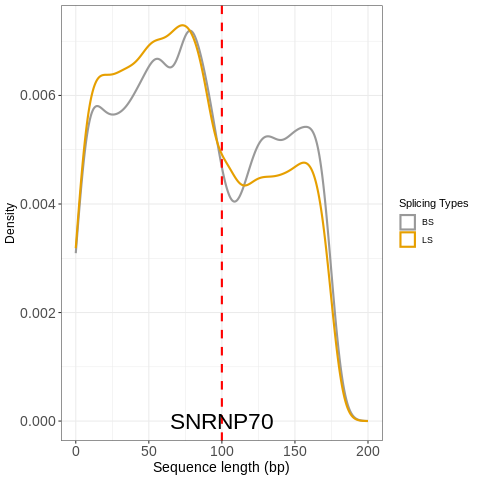

In [188]:
%%R
Fig1

In [189]:
def activation_density_df_base_model1(ppm_extraction_BS,
                                      ppm_extraction_LS, 
                                      BS_kernel_num,
                                      LS_kernel_num):
    
        ## compare the motif distribution for BS and LS in the upper sequence

    BS_activation_list = ppm_extraction_BS.subseq_starting_index_all_kernel[BS_kernel_num].copy()
    LS_activation_list = ppm_extraction_LS.subseq_starting_index_all_kernel[LS_kernel_num].copy()

        
    
    ## check if the two list have the same length before put them in a dataframe
    BS_activation_series = pd.Series(BS_activation_list, name='BS')
    LS_activation_series = pd.Series(LS_activation_list, name='LS')
    
    
    ## get the long df form with melt setting the grouping variables "LS" and "BS"
    df = pd.concat([LS_activation_series, BS_activation_series], axis=1).melt()
    
    ## drop the missing values (the instances where activation values are non positive)
    
    df_ = df.dropna()
    return df_

In [215]:
max_activation_df = activation_density_df_base_model1(
                                  ppm_extraction_BS=Base_model1_10000_ppm_extraction_BS,
                                  ppm_extraction_LS=Base_model1_10000_ppm_extraction_LS,
                                  LS_kernel_num=421, BS_kernel_num=421)

In [216]:
%%R -i max_activation_df -o Fig1

My_Theme = theme(
  axis.title.x = element_text(size = 14),
  axis.text.x = element_text(size = 14),
  axis.title.y = element_text(size = 12),
  axis.text.y = element_text(size = 14))


Fig1 <- ggplot(max_activation_df, aes(x=value, color=variable)) + geom_density(size=1) +
    geom_vline(xintercept=200, linetype="dashed", color="red", size=1) + 
    xlim(c(0, 400)) +

    annotate("text", x=200, y=0, label= "MBNL1", size=8) +
    scale_color_manual(values=c("#999999", "#E69F00")) + 
    xlab('Sequence length (bp)') + ylab('Density') +
    labs(color='Splicing Types') +
    theme_bw() + My_Theme 

Fig1

ggsave(file=file.path('/home/wangc90/circRNA/circRNA_Data/model_outputs/Extracted_motifs/Motif_density_plot/', 'Model1_10000_MBNL1_2.svg'),
       width=5, height=4)

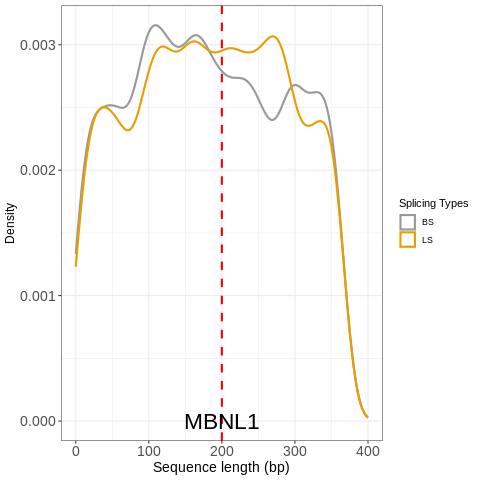

In [217]:
%%R
Fig1